<a href="https://colab.research.google.com/github/stenoe/FEDS/blob/main/notebooks/LectureNotebooks/FEDS_lecture_17_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create a Neural Network to describe net ecosystem exchange

In this lecture I will use real data from SMEAR in the COVID year 2020 on carbon fluxes. We will implement together a simple neural network to assess the daily dynamic from one month of data

## 1. Download the data from the lecture repository

In [ ]:
import requests
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")

# If the data folder doesn't exist, download it and prepare it...
if data_path.is_dir():
  print(f"{data_path} directory already exists... skipping creation")
else: 
  print(f"{data_path} does not exist, creating one...")
  data_path.mkdir(parents=True, exist_ok=True)

# Download data
with open(data_path / "NEE_data.csv", "wb") as f:
  request = requests.get("https://raw.githubusercontent.com/stenoe/FEDS/main/data/NEE_data.csv")
  print("Downloading data...")
  f.write(request.content)

data directory already exists... skipping creation


## 2. Import the data and get a short overview

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv(data_path / "NEE_data.csv")
df.head()

,timestamp,Year,Month,Day,Hour,DoY,Tair_f,NEE_f,GPP_f,Reco
0,2020-01-01 00:00:00,2020,1,1,0.0,1,-1.823,0.93385,0.037139,0.970984
1,2020-01-01 00:30:00,2020,1,1,0.5,1,-2.031,0.73878,0.217870,0.956651
2,2020-01-01 01:00:00,2020,1,1,1.0,1,-2.285,1.05920,-0.119840,0.939356
3,2020-01-01 01:30:00,2020,1,1,1.5,1,-2.342,0.58402,0.351130,0.935153
4,2020-01-01 02:00:00,2020,1,1,2.0,1,-2.487,0.56388,0.361290,0.925168


### 2.1 Plot one month of data

I use here June as example, feel free to use another one.

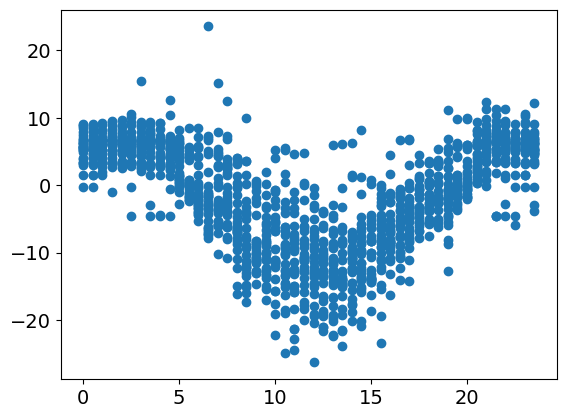

In [ ]:
plt.scatter(df[df.Month==6].Hour, df[df.Month==6].NEE_f);

## 3. Import the `PyTorch` library

`PyTorch` is the AI/ML library by Meta (Facebook). There is also `TensorFlow` developed by Google. The basic concepts and functionality is rather similar.

The base of both libraries are **tensors**. A tensor is in machine learning a multilinear map to keep and transform any kind of data.

(https://en.wikipedia.org/wiki/Tensor_(machine_learning))

Let's import the `torch`library and some helpers

In [ ]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

torch.__version__

'2.0.1+cu118'

### 3.1 Writing decive agnostic code

ML model training can be speeded up by using specialised hardware. Typically, we can use Graphic processors (GPUs) because these are optimised to process tensor data.

In Colab, we need to choose the right **runtime**, one with a GPU enabled.

To see which hardware we got we can execute the following command:

In [ ]:
!nvidia-smi

Tue May 30 18:25:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |    821MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### 3.1.1 Get the GPU type and set it as device

Currently, there are either NVidia CUDA GPUs available on Intel platforms and the Metal Performance Shader (mps) on Apple Silicon systems.





In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 4. Prepare the data for use with PyTorch

In this section I use the data we did load from the csv file into a dataframe and transfer them into tensors. 

I transform them into numpy arrays before, however, there is a possibility to convert the data directly from dataframes to tensors. It is in any case needed to specify the `type`, here `torch.float`. Often, too large datatypes can cause problems when using GPU hardware. `torch.float` is choosing the **proper** type for the hardware.

In [ ]:
RANDOM_SEED = 42


X = torch.from_numpy(df[df.Month==6].Hour.to_numpy()).type(torch.float).unsqueeze(dim=1) 
y = torch.from_numpy(df[df.Month==6].NEE_f.to_numpy()).type(torch.float).unsqueeze(dim=1)


# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_SEED
)


In [ ]:
X_train[:5], X_test[:5]

(tensor([[22.0000],
         [ 2.5000],
         [14.5000],
         [ 8.5000],
         [14.5000]]),
 tensor([[12.0000],
         [14.5000],
         [10.0000],
         [ 8.5000],
         [ 2.0000]]))

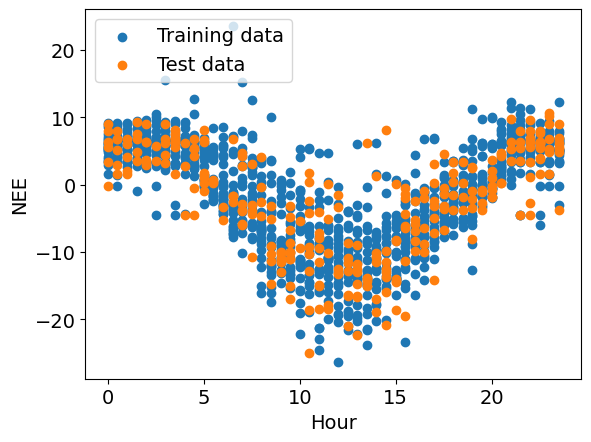

In [ ]:
# Let's visualise our chosen data
plt.scatter(X_train, y_train, label="Training data")
plt.scatter(X_test, y_test, label="Test data")
plt.xlabel("Hour")
plt.ylabel("NEE")
plt.legend(loc='upper left')
plt.show()

## 5. Setting up the neural network

I use a deep normal network structure (DNN) that in this simpler case has al together three layers, one input layer, one hidden layer and one output layer that is connected via a sigmoid activiation function.

I use the `torch.nn.Module` class and create a subclass where I implement the needed layers and the forward function that if fitting to the problem.

- The input layer consists of one neuron, because the input is the feature is one hour value. 

- The hidden layer has 10 neurons that can be adapted by the forward and back-propagation steps to match the patterns in the data.

- The output layer uses and sigmoid activation function (aka transfer function) that allows to switch the neuron on or off in a network and decides by that if that neuron has an important imput to the network or not.

In [ ]:
class DeepNormalModel(nn.Module):
    def __init__(self, n_inputs: int = 1, n_hidden: int = 10):
        super().__init__()
        self.hidden = torch.nn.Linear(n_inputs, n_hidden)
        self.mean_linear = torch.nn.Linear(n_hidden, 1)
        
    def forward(self, x):
        outputs = self.hidden(x)
        outputs = torch.sigmoid(outputs)

        mean = self.mean_linear(outputs)
        return mean

# Instantiate the model and send it to the GPU
model_0 = DeepNormalModel().to(device)

In [ ]:
model_0

DeepNormalModel(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (mean_linear): Linear(in_features=10, out_features=1, bias=True)
)

### 5.1 Defining the loss function and the optimiser

Remember from the gradient descent lecture, we need some criterion to decide if the step made has led to a better approximation of the data. In this regression problem, I use the `torch.nn.L1Loss` function. It measures the mean absolute error between each element in the input $X$ and the target $y$. 

The optimiser, here Adam (a variation of the gradient descent including stochastic elements) algorithm is used. The method takes the models parameters that need to be optimised and the learning rate into account.

In [ ]:
# Set a loss function, use mean absolute error (MAE)
loss_fn = nn.L1Loss()

# Set optimisers, use gradient descent
optimiser = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.05)

### 5.2 The "heart" of the learning algorithm 

The training loop that will train the model on the given training data set.

The steps are as follows:

1. switch to training mode
2. copy the data to the GPU
3. calculate the forward pass / step and store the model result
4. calculate the loss by comapring the labels with the current calculated prediction
5. reset gradients
6. make the backward propoagation, set the result from the model as new input. 
7. perform the optimisation step

The rest of the code is to have an overview if the model learns at all something. 

1. switch to evaluation / inference mode
2. make a prediction with the test data
3. calculate the loss of the test data
4. print the resutls to visualise the steps of the algorithm

In [ ]:
# Trainig loop 
torch.manual_seed(42)

epochs = 300

for epoch in range(epochs):
    # Switch the system into training mode
    model_0.train()

    # Copy data to the GPU
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    # forward pass
    y_pred = model_0(X_train)

    # Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # Set optimisers gradients to zero
    optimiser.zero_grad()

    # Perform backpropagation steps
    loss.backward()

    # Optimiser step
    optimiser.step()

    ### Testing
    if epoch % 20 == 0: # run testing every 20th epoch
        # Switch model to evaluation mode
        model_0.eval()

        with torch.inference_mode():
            X_test  = X_test.to(device)
            y_test  = y_test.to(device)

            test_pred = model_0(X_test)

            test_loss = loss_fn(test_pred, y_test)

        # Print out what happens
        print(f"Model 0 - Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")



Model 0 - Epoch: 0 | Loss: 6.636252403259277 | Test loss: 6.739497661590576
Model 0 - Epoch: 20 | Loss: 6.067663669586182 | Test loss: 6.221339702606201
Model 0 - Epoch: 40 | Loss: 5.4118523597717285 | Test loss: 5.794424057006836
Model 0 - Epoch: 60 | Loss: 5.370665073394775 | Test loss: 5.752039432525635
Model 0 - Epoch: 80 | Loss: 5.316307067871094 | Test loss: 5.69956636428833
Model 0 - Epoch: 100 | Loss: 5.274261951446533 | Test loss: 5.667341709136963
Model 0 - Epoch: 120 | Loss: 5.249062538146973 | Test loss: 5.640868663787842
Model 0 - Epoch: 140 | Loss: 5.236565589904785 | Test loss: 5.624183177947998
Model 0 - Epoch: 160 | Loss: 5.229694843292236 | Test loss: 5.614455223083496
Model 0 - Epoch: 180 | Loss: 5.225088596343994 | Test loss: 5.608790874481201
Model 0 - Epoch: 200 | Loss: 5.221670150756836 | Test loss: 5.605607032775879
Model 0 - Epoch: 220 | Loss: 5.193411350250244 | Test loss: 5.563192844390869
Model 0 - Epoch: 240 | Loss: 5.025697708129883 | Test loss: 5.35306024

### 5.3 Evaluate the model using test data

In [ ]:
model_0.eval()

with torch.inference_mode():
    y_pred = model_0(X_test)


### 5.4 Helper function for visual presentation of the regression

In [ ]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None,
                     save_png=None
                    ):
    """
    Plots trainig data, test data and compares predictions
    """
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(10, 7))
    
    # Plot training data in blue, matplotlib need data on the CPU!
    plt.scatter(train_data.cpu(), train_labels.cpu(), c="b", s=12, alpha=0.5, label="Training data")
    
    # Plot testing data in green
    plt.scatter(test_data.cpu(), test_labels.cpu(), c="g", s=12, alpha=0.3, label="Testing data")
    
    # do we have predictions?
    if predictions is not None:
        
        px = pd.DataFrame({
            "x": np.ndarray.flatten(test_data.cpu().numpy()),
            "y": np.ndarray.flatten(predictions.cpu().numpy())
        })
        px.sort_values(by=["x"], inplace=True)
        plt.plot(px.x, px.y, c="r", linewidth=3.0, label="Prediction")
    
    # show legend
    plt.legend(prop={"size": 14});
    
    # axis labels
    plt.xlabel("Hour")
    plt.ylabel("NEE")
    
    # saving wanted?
    if save_png is not None:
        plt.savefig("saved.png", dpi=600)
    

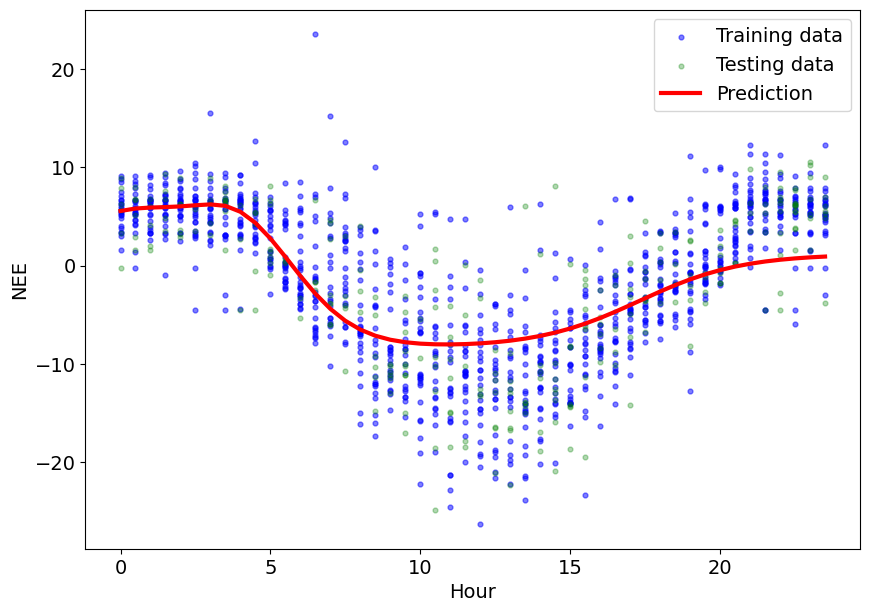

In [ ]:
plot_predictions(predictions=y_pred.cpu())